This is the last assignment for the Coursera course "Advanced Machine Learning and Signal Processing"

Just execute all cells one after the other and you are done - just note that in the last one you should update your email address (the one you've used for coursera) and obtain a submission token, you get this from the programming assignment directly on coursera.

Please fill in the sections labelled with "###YOUR_CODE_GOES_HERE###"

The purpose of this assignment is to learn how feature engineering boosts model performance. You will apply Discrete Fourier Transformation on the accelerometer sensor time series and therefore transforming the dataset from the time to the frequency domain. 

After that, you’ll use a classification algorithm of your choice to create a model and submit the new predictions to the grader. Done.

Please make sure you run this notebook from an Apache Spark 2.3 notebook.

So the first thing we need to ensure is that we are on the latest version of SystemML, which is 1.3.0 (as of 20th March'19) Please use the code block below to check if you are already on 1.3.0 or higher. 1.3 contains a necessary fix, that's we are running against the SNAPSHOT


In [1]:
from systemml import MLContext
ml = MLContext(spark)
ml.version()

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190425190700-0001
KERNEL_ID = a4a1225e-b6f3-40c4-a373-6e6969c4a8da


'1.3.0-SNAPSHOT'



If you are blow version 1.3.0, or you got the error message "No module named 'systemml'"  please execute the next two code blocks and then

# PLEASE RESTART THE KERNEL !!!

Otherwise your changes won't take effect, just double-check every time you run this notebook if you are on SystemML 1.3


In [ ]:
!pip install https://github.com/IBM/coursera/blob/master/systemml-1.3.0-SNAPSHOT-python.tar.gz?raw=true



Now we need to create two sym links that the newest version is picket up - this is a workaround and will be removed as soon as SystemML 1.3 will be pre-installed on Watson Studio once officially released.


In [ ]:
!ln -s -f ~/user-libs/python3/systemml/systemml-java/systemml-1.3.0-SNAPSHOT-extra.jar ~/user-libs/spark2/systemml-1.3.0-SNAPSHOT-extra.jar
!ln -s -f ~/user-libs/python3/systemml/systemml-java/systemml-1.3.0-SNAPSHOT.jar ~/user-libs/spark2/systemml-1.3.0-SNAPSHOT.jar

# Please now restart the kernel and start from the beginning to make sure you've installed SystemML 1.3

Let's download the test data since it's so small we don't use COS (IBM Cloud Object Store) here

In [2]:
!wget https://github.com/IBM/coursera/blob/master/coursera_ml/shake.parquet?raw=true
!mv shake.parquet?raw=true shake.parquet

--2019-04-25 19:21:52--  https://github.com/IBM/coursera/blob/master/coursera_ml/shake.parquet?raw=true
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/IBM/coursera/raw/master/coursera_ml/shake.parquet [following]
--2019-04-25 19:21:52--  https://github.com/IBM/coursera/raw/master/coursera_ml/shake.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/coursera/master/coursera_ml/shake.parquet [following]
--2019-04-25 19:21:53--  https://raw.githubusercontent.com/IBM/coursera/master/coursera_ml/shake.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting respo

Now it’s time to read the sensor data and create a temporary query table.

In [3]:
df=spark.read.parquet('shake.parquet')

In [4]:
df.show()

+-----+---------+-----+-----+-----+
|CLASS| SENSORID|    X|    Y|    Z|
+-----+---------+-----+-----+-----+
|    2| qqqqqqqq| 0.12| 0.12| 0.12|
|    2|aUniqueID| 0.03| 0.03| 0.03|
|    2| qqqqqqqq|-3.84|-3.84|-3.84|
|    2| 12345678| -0.1| -0.1| -0.1|
|    2| 12345678|-0.15|-0.15|-0.15|
|    2| 12345678| 0.47| 0.47| 0.47|
|    2| 12345678|-0.06|-0.06|-0.06|
|    2| 12345678|-0.09|-0.09|-0.09|
|    2| 12345678| 0.21| 0.21| 0.21|
|    2| 12345678|-0.08|-0.08|-0.08|
|    2| 12345678| 0.44| 0.44| 0.44|
|    2|    gholi| 0.76| 0.76| 0.76|
|    2|    gholi| 1.62| 1.62| 1.62|
|    2|    gholi| 5.81| 5.81| 5.81|
|    2| bcbcbcbc| 0.58| 0.58| 0.58|
|    2| bcbcbcbc|-8.24|-8.24|-8.24|
|    2| bcbcbcbc|-0.45|-0.45|-0.45|
|    2| bcbcbcbc| 1.03| 1.03| 1.03|
|    2|aUniqueID|-0.05|-0.05|-0.05|
|    2| qqqqqqqq|-0.44|-0.44|-0.44|
+-----+---------+-----+-----+-----+
only showing top 20 rows



In [5]:
!pip install pixiedust

    100% |################################| 204kB 2.7MB/s eta 0:00:01
    100% |################################| 798kB 3.4MB/s eta 0:00:01
    100% |################################| 5.6MB 1.8MB/s eta 0:00:01
    100% |################################| 92kB 3.4MB/s eta 0:00:01
    100% |################################| 61kB 2.1MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/73/fb/00a976f728d0d1fecfe898238ce23f502a721c0ac0ecfedb80e0d88c64e9/six-1.12.0-py2.py3-none-any.whl
    100% |################################| 583kB 4.0MB/s eta 0:00:01
    100% |################################| 133kB 4.1MB/s eta 0:00:01
    100% |################################| 143kB 3.5MB/s eta 0:00:01
    100% |################################| 163kB 3.2MB/s eta 0:00:01
    100% |################################| 61kB 2.2MB/s eta 0:00:01
  Running setup.py bdist_wheel for pixiedust ... done
  Stored in directory: /home/spark/shared/.cache/pip/wheels/ee/53/a8/7a2ed392a416ec3eaa4eef4f49


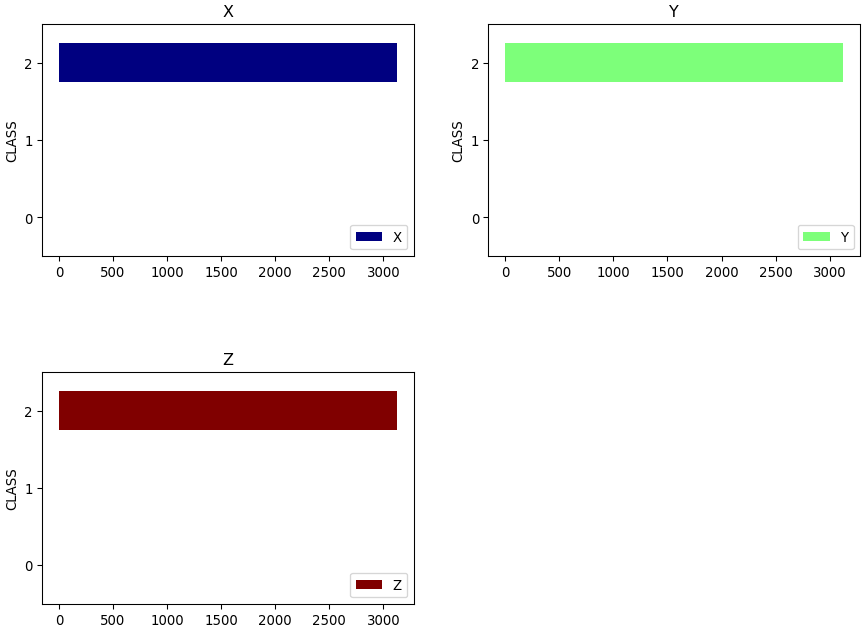

In [6]:
import pixiedust
display(df)

In [7]:
df.createOrReplaceTempView("df")

We’ll use Apache SystemML to implement Discrete Fourier Transformation. This way all computation continues to happen on the Apache Spark cluster for advanced scalability and performance.

In [8]:
from systemml import MLContext, dml
ml = MLContext(spark)

As you’ve learned from the lecture, implementing Discrete Fourier Transformation in a linear algebra programming language is simple. Apache SystemML DML is such a language and as you can see the implementation is straightforward and doesn’t differ too much from the mathematical definition (Just note that the sum operator has been swapped with a vector dot product using the %*% syntax borrowed from R
):

<img style="float: left;" src="https://wikimedia.org/api/rest_v1/media/math/render/svg/1af0a78dc50bbf118ab6bd4c4dcc3c4ff8502223">



In [9]:
dml_script = '''
PI = 3.141592654
N = nrow(signal)

n = seq(0, N-1, 1)
k = seq(0, N-1, 1)

M = (n %*% t(k))*(2*PI/N)

Xa = cos(M) %*% signal
Xb = sin(M) %*% signal

DFT = cbind(Xa, Xb)
'''

Now it’s time to create a function which takes a single row Apache Spark data frame as argument (the one containing the accelerometer measurement time series for one axis) and returns the Fourier transformation of it. In addition, we are adding an index column for later joining all axis together and renaming the columns to appropriate names. The result of this function is an Apache Spark DataFrame containing the Fourier Transformation of its input in two columns. 


In [10]:
from pyspark.sql.functions import monotonically_increasing_id

def dft_systemml(signal,name):
    prog = dml(dml_script).input('signal', signal).output('DFT')
    
    return (

    #execute the script inside the SystemML engine running on top of Apache Spark
    ml.execute(prog) 
     
         #read result from SystemML execution back as SystemML Matrix
        .get('DFT') 
     
         #convert SystemML Matrix to ApacheSpark DataFrame 
        .toDF() 
     
         #rename default column names
        .selectExpr('C1 as %sa' % (name), 'C2 as %sb' % (name)) 
     
         #add unique ID per row for later joining
        .withColumn("id", monotonically_increasing_id())
    )
        




Now it’s time to create DataFrames containing for each accelerometer sensor axis and one for each class. This means you’ll get 6 DataFrames. Please implement this using the relational API of DataFrames or SparkSQL.


In [52]:
x0 = df.select('CLASS', 'X').filter(df.CLASS == 0)###YOUR_CODE_GOES_HERE### => Please create a DataFrame containing only measurements of class 0 from the x axis
y0 = df.select('CLASS', 'Y').filter(df.CLASS == 0)###YOUR_CODE_GOES_HERE### => Please create a DataFrame containing only measurements of class 0 from the y axis
z0 = df.select('CLASS', 'Z').filter(df.CLASS == 0)###YOUR_CODE_GOES_HERE### => Please create a DataFrame containing only measurements of class 0 from the z axis
x1 = df.select('CLASS', 'X').filter(df.CLASS == 1)###YOUR_CODE_GOES_HERE### => Please create a DataFrame containing only measurements of class 1 from the x axis
y1 = df.select('CLASS', 'Y').filter(df.CLASS == 1)###YOUR_CODE_GOES_HERE### => Please create a DataFrame containing only measurements of class 1 from the y axis
z1 = df.select('CLASS', 'Z').filter(df.CLASS == 1)###YOUR_CODE_GOES_HERE### => Please create a DataFrame containing only measurements of class 1 from the z axis

Since we’ve created this cool DFT function before, we can just call it for each of the 6 DataFrames now. And since the result of this function call is a DataFrame again we can use the pyspark best practice in simply calling methods on it sequentially. So what we are doing is the following:

- Calling DFT for each class and accelerometer sensor axis.
- Joining them together on the ID column. 
- Re-adding a column containing the class index.
- Stacking both Dataframes for each classes together



In [53]:
from pyspark.sql.functions import lit

df_class_0 = dft_systemml(x0,'x') \
    .join(dft_systemml(y0,'y'), on=['id'], how='inner') \
    .join(dft_systemml(z0,'z'), on=['id'], how='inner') \
    .withColumn('class', lit(0))
    
df_class_1 = dft_systemml(x1,'x') \
    .join(dft_systemml(y1,'y'), on=['id'], how='inner') \
    .join(dft_systemml(z1,'z'), on=['id'], how='inner') \
    .withColumn('class', lit(1))

df_dft = df_class_0.union(df_class_1)

df_dft.show()

SystemML Statistics:
Total execution time:		0.013 sec.
Number of executed Spark inst:	0.


SystemML Statistics:
Total execution time:		0.000 sec.
Number of executed Spark inst:	0.


SystemML Statistics:
Total execution time:		0.000 sec.
Number of executed Spark inst:	0.


SystemML Statistics:
Total execution time:		0.772 sec.
Number of executed Spark inst:	0.


SystemML Statistics:
Total execution time:		0.113 sec.
Number of executed Spark inst:	0.


SystemML Statistics:
Total execution time:		0.106 sec.
Number of executed Spark inst:	0.


+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|        id|                  xa|                  xb|                  ya|                  yb|                  za|                  zb|class|
+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|8589934592|       

Please create a VectorAssembler which consumes the newly created DFT columns and produces a column “features”


In [54]:
from pyspark.ml.feature import VectorAssembler

In [61]:
vectorAssembler = VectorAssembler(
    inputCols=["id", "xa", "xb", "ya", "yb", "za", "class"],
    outputCol="features")

Please insatiate a classifier from the SparkML package and assign it to the classifier variable. Make sure to set the “class” column as target.


In [62]:
from pyspark.ml.classification import GBTClassifier

In [66]:
classifier = GBTClassifier(labelCol="class")

Let’s train and evaluate…


In [67]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[vectorAssembler, classifier])

In [68]:
model = pipeline.fit(df_dft)

In [69]:
prediction = model.transform(df_dft)

In [70]:
prediction.show()

+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+----------+
|        id|                  xa|                  xb|                  ya|                  yb|                  za|                  zb|class|            features|       rawPrediction|         probability|prediction|
+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+----------+
|8589934592|                 0.0|                 0.0|                 0.0|                 0.0|                 0.0|                 0.0|    0|(7,[0],[8.5899345...|[1.54350200272498...|[0.95635347857270...|       0.0|
|         0|                 0.0|                 0.0|                 0.0|                 0.0|                 0.0|       

In [71]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
binEval = MulticlassClassificationEvaluator().setMetricName("accuracy") .setPredictionCol("prediction").setLabelCol("class")
    
binEval.evaluate(prediction) 

1.0

If you are happy with the result (I’m happy with > 0.8) please submit your solution to the grader by executing the following cells, please don’t forget to obtain an assignment submission token (secret) from the Courera’s graders web page and paste it to the “secret” variable below, including your email address you’ve used for Coursera. 


In [72]:
!rm -Rf a2_m4.json

In [73]:
prediction = prediction.repartition(1)
prediction.write.json('a2_m4.json')

In [74]:
!rm -f rklib.py
!wget wget https://raw.githubusercontent.com/IBM/coursera/master/rklib.py

--2019-04-25 20:11:34--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address 'wget'
--2019-04-25 20:11:34--  https://raw.githubusercontent.com/IBM/coursera/master/rklib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2540 (2.5K) [text/plain]
Saving to: 'rklib.py'

rklib.py            100%[===================>]   2.48K  --.-KB/s    in 0s      

2019-04-25 20:11:34 (22.9 MB/s) - 'rklib.py' saved [2540/2540]

FINISHED --2019-04-25 20:11:34--
Total wall clock time: 0.2s
Downloaded: 1 files, 2.5K in 0s (22.9 MB/s)


In [75]:
from rklib import zipit
zipit('a2_m4.json.zip','a2_m4.json')

In [76]:
!base64 a2_m4.json.zip > a2_m4.json.zip.base64

In [83]:
from rklib import submit
key = "-fBiYHYDEeiR4QqiFhAvkA"
part = "IjtJk"
email = "nicholas.m.uhorchak.mil@mail.mil"
submission_token = "RXUoKnsfXmyCTxUZ"

with open('a2_m4.json.zip.base64', 'r') as myfile:
    data=myfile.read()
submit(email, submission_token, key, part, [part], data)

Submission successful, please check on the coursera grader page for the status
-------------------------
{"elements":[{"itemId":"B8wXV","id":"f_F-qCtuEei_fRLwaVDk3g~B8wXV~c_-lqWeWEemHUxIMG5X3iA","courseId":"f_F-qCtuEei_fRLwaVDk3g"}],"paging":{},"linked":{}}
-------------------------
